In [2]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.utils.track_utils import RaceTrack, CentreLine
from f1tenth_benchmarks.data_tools.plotting_utils import *

from f1tenth_benchmarks.data_tools.general_plotting.plot_trajectory_analysis import plot_trajectory_analysis
from f1tenth_benchmarks.data_tools.general_plotting.plot_raceline_tracking import plot_raceline_tracking

from f1tenth_benchmarks.run_scripts.run_functions import *
import numpy as np


if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


## TODOs
- Set up global parameters for data generation and plotting.

# Load Data

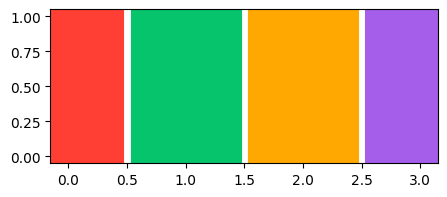

In [3]:


planners = ['FullStackPP', "FullStackMPCC", "FollowTheGap", "EndToEnd"]
test_ids = ["ts_t1", "mpcc_t1", "Std", "TD3_TAL_12_gbr"]
neat_planner_names = ["Optimisation and tracking", "MPCC", "Follow-the-gap", "End-to-end"]
n_planners = len(planners)
planner_colors = [red_orange, sweedish_green, chrome_yellow, lighter_purple]

plt.figure(figsize=(5, 2))
for i in range(n_planners):
    plt.plot([i, i], [0, 1], color=planner_colors[i], linewidth=80)
    
map_list = ["aut", "esp", "gbr", "mco"]


In [4]:
summary_df = pd.read_csv("Logs/Summary.csv")
results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

times_df = results_df[['Vehicle', 'MapName', 'AvgTime']]
times_df = times_df.pivot(index="Vehicle", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
times_df.sort_values(by="Vehicle", inplace=True, ascending=False)
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")

MapName                        AUT     ESP     GBR     MCO
Vehicle                                                   
Optimisation and tracking  17.1040  36.656  31.888  29.272
MPCC                       18.7800  42.160  38.720  34.512
Follow-the-gap             19.1156  45.740  39.328  35.028
End-to-end                 19.9440  44.568  39.800  36.576


In [5]:
#TODO: This data should be formed into a single table and then saved to a csv file for later use.....
n_laps = 5
lap_dfs = []
for i, planner_name in enumerate(planners):
    for m, map_name in enumerate(map_list):
        for lap_n in range(n_laps):
            data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
            df.steer_a = df.steer_a * 180 / np.pi
            df.yaw = df.yaw * 180 / np.pi
            df.slip = df.slip.abs() * 180 / np.pi
            df["lap_n"] = lap_n
            df["planner"] = planner_name
            df["map_name"] = map_name

            lap_dfs.append(df)


lap_df = pd.concat(lap_dfs)
lap_df.loc[lap_df["progress"] < 0.05, "speed_error"] = 0
lap_df.loc[lap_df["progress"] < 0.02, "curvature"] = 0
print(f"Lap data shape: {lap_df.shape}, nPlanners: {lap_df.planner.nunique()}")


Lap data shape: (56896, 15), nPlanners: 4


/tmp/ipykernel_450445/3974429998.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


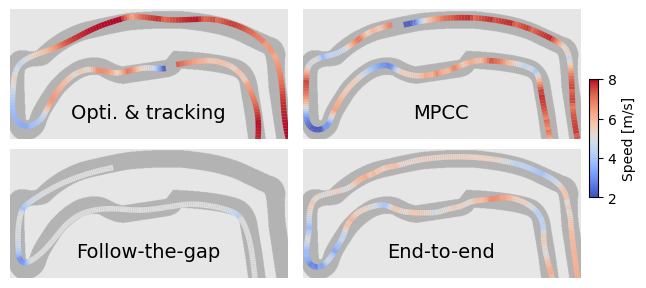

In [6]:
plot_map = "mco"
map_data = MapData(plot_map)
neat_planner_names[0] = "Opti. & tracking"

fig, axs = plt.subplots(2, 2, figsize=(6., 3), sharex=True, sharey=True)
axs_list = axs.flatten()
for i in range(n_planners):
    plt.sca(axs_list[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 4]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(2, 8)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(4)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs_list[i].set_aspect('equal')
    plt.xlim(60, 650)
    plt.ylim(725, 1000)

    plt.text(0.5, 0.2, neat_planner_names[i], horizontalalignment='center', verticalalignment='center', transform=axs_list[i].transAxes, size=14)

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.09, ax.get_position().y0+0.2, 0.015, ax.get_position().height*1.2])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])

plt.tight_layout()

plt.savefig(f"{save_path}speed_trajectories_{map_name}.pdf", bbox_inches='tight')

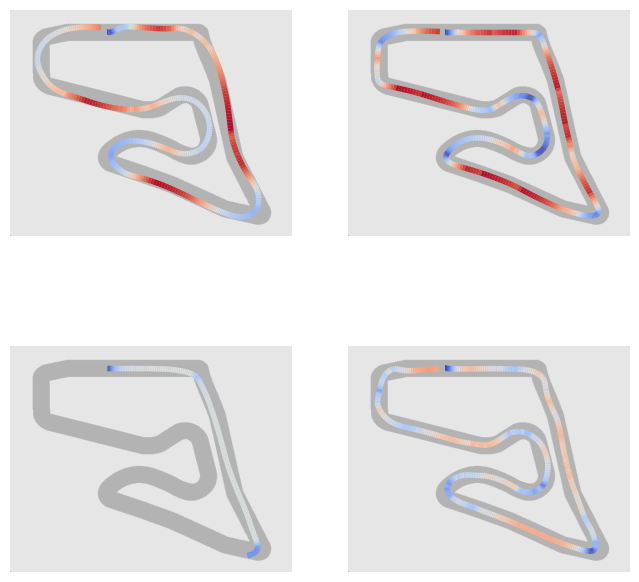

In [7]:
plot_map = "aut"
map_data = MapData(plot_map)

plot_df = lap_df[lap_df["map_name"] == plot_map]
plot_df = plot_df[plot_df['lap_n'] == 0]
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axs_list = axs.flatten()
for i in range(n_planners):
    plt.sca(axs_list[i])
    map_data.plot_map_img()

    df = plot_df[plot_df["planner"] == planners[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(2, 8)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(4)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs_list[i].set_aspect('equal')
    # plt.xlim(60, 650)
    # plt.ylim(725, 1000)

    # plt.text(0.5, 0.2, neat_planner_names[i], horizontalalignment='center', verticalalignment='center', transform=axs_list[i].transAxes, size=14)

# ax = plt.gca()
# cax = fig.add_axes([ax.get_position().x1+0.09, ax.get_position().y0+0.2, 0.015, ax.get_position().height*1.2])
# plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])

# plt.tight_layout()


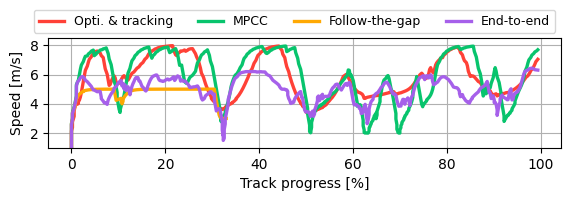

In [13]:
map_name = "aut"

fig, ax1 = plt.subplots(1, 1, figsize=(6., 2.2), sharex=True)

map_df = lap_df[lap_df["map_name"] == map_name]
map_df = map_df[map_df['lap_n'] == 0]

for i in range(4):
    df = map_df[map_df["planner"] == planners[i]]
    ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

ax1.grid(True)
ax1.set_ylim(1., 8.5)
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=9)
plt.xlabel("Track progress [%]")
plt.ylabel("Speed [m/s]")

plt.tight_layout()
plt.savefig(f"{save_path}speed_comparison_{map_name}.pdf", bbox_inches='tight', pad_inches=0.0)
plt.savefig(f"{save_path}speed_comparison_{map_name}.svg", bbox_inches='tight', pad_inches=0.0)

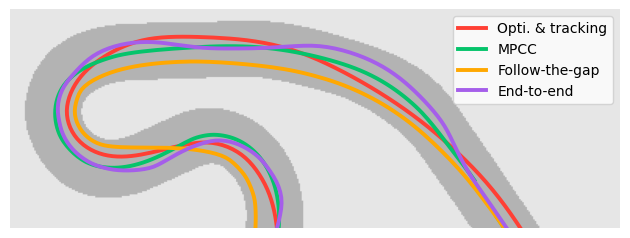

In [9]:
plot_map = "gbr"
map_data = MapData(plot_map)

mini_df = lap_df[lap_df["map_name"] == plot_map]
mini_df = mini_df[mini_df['lap_n'] == 3]

map_data.plot_map_img()
for i in range(n_planners):
    df = mini_df[mini_df["planner"] == planners[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, linewidth=2.8, color=planner_colors[i], label=neat_planner_names[i])
    
plt.axis('off')
plt.legend()
plt.xlim(840, 1230)
plt.ylim(720, 860)

plt.tight_layout()
plt.savefig(f"{save_path}path_comparison_{plot_map}.svg", bbox_inches='tight', pad_inches=0)
plt.savefig(f"{save_path}path_comparison_{plot_map}.pdf", bbox_inches='tight', pad_inches=0)


In [10]:
map_name = "aut"
perception_id = ["localise", "localise", None, None]
planning_times = np.zeros(n_planners)
perception_times = np.zeros(n_planners)

for i in range(n_planners):
    # print(f"Planner: {planners[i]} --> test_id: {test_ids[i]} --> NeatName: {neat_planner_names[i]}")
    path = f"Logs/{planners[i]}/RawData_{test_ids[i]}/"

    df = pd.read_csv(path + f"Profile_{map_name}_{test_ids[i]}.csv")
    df["cumtime"] = df["cumtime"].astype(float, errors="ignore")  # Convert cumtime column to float
    df["ncalls"] = pd.to_numeric(df["ncalls"], errors='coerce')  # Convert cumtime column to float

    planning = df.loc[df["func"] == "plan"]
    planning_time = planning.cumtime.values[0] / planning.ncalls.values[0]
    planning_times[i] = planning_time

    if perception_id[i] is not None:
        perception = df.loc[df["func"] == perception_id[i]]
        perception_time = perception["cumtime"].values[0] / perception["ncalls"].values[0]
        perception_times[i] = perception_time

plt.figure(figsize=(5, 2))
print(f"Planning times: {planning_times}")
print(f"Perception times: {perception_times}")

planning_times[1] = 0.005 #! TEMP REMOVE

plt.bar(neat_planner_names, planning_times, color=sweedish_green, label="Planning")
plt.bar(neat_planner_names, perception_times, bottom=planning_times, color=nartjie, label="Perception")

plt.plot(plt.xlim(), [0.04, 0.04], 'k--', linewidth=1.5, label="25 Hz")
plt.legend(fontsize=9, loc="upper right")
plt.gca().set_xticklabels(neat_planner_names, fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel("Computation time [s]", fontsize=9)
plt.yscale('log')
plt.ylim(0.00005, 0.1)
plt.tight_layout()
plt.grid()
plt.rcParams['pdf.use14corefonts'] = True

plt.savefig(f"{save_path}computation_times.svg", bbox_inches='tight', pad_inches=0)
plt.savefig(f"{save_path}computation_times.pdf", bbox_inches='tight', pad_inches=0)


IndexError: index 0 is out of bounds for axis 0 with size 0